### Importing necessary packages

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

### Reading the data

In [2]:
mnist = tf.keras.datasets.mnist

# Dataset will be cached locally after you run this code
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# These types are required for the operation we use to compute
# loss. Omit, and you shall receive a cryptic error message.
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

### Defining the batch size

In [3]:
buffer_size = 5000
batch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size)
train_dataset = train_dataset.batch(batch_size)

### Defining the Model Class

In [4]:
class Model(tf.keras.Model):
    def __init__(self, deep=False, activation=tf.nn.relu, kernel_initializer = 'glorot_normal'):
        super(Model, self).__init__()
        self.deep = deep
        self.activation = activation
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation=activation, kernel_initializer = kernel_initializer)
        self.dropout1 = tf.keras.layers.Dropout(0.2)
        self.dense2 = tf.keras.layers.Dense(128, activation=activation, kernel_initializer = kernel_initializer)
        self.dropout2 = tf.keras.layers.Dropout(0.2)
        self.dense3 = tf.keras.layers.Dense(10, kernel_initializer = kernel_initializer)


    def call(self, x):
        x = self.flatten(x)
        if self.deep:
            x = self.dense1(x)
            x = self.dropout1(x)
            x = self.dense2(x)
            x = self.dropout2(x)
        x = self.dense3(x)
        return x # be sure to return logits, not softmax output

In [5]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

### Defining the loss, accuracy and train functions

In [6]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = labels))

In [7]:
def compute_accuracy(logits, labels):
  # You shoud not need to modify this function
    predictions = tf.argmax(logits, axis=1)
    batch_size = int(logits.shape[0])
    return tf.reduce_sum(
      tf.cast(tf.equal(predictions, labels), dtype=tf.float32)) / batch_size

In [8]:
def train(model, images, labels, optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.1)):
    # You should not need to modify this function
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss_value

## Linear Model - Part 2 Question 3 and Question 4

In [105]:
model = Model(deep=False, activation=tf.nn.relu)

epochs = 10
step_counter = 0

model_metrics_linear = {}
model_metrics_linear['training_loss'] = []
model_metrics_linear['test_accuracy'] = []
model_metrics_linear['test_loss'] = []


writer = tf.contrib.summary.create_file_writer(logdir="logs/linear_model", flush_millis=1000)
with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch_n in range(epochs):
            print('Epoch #%d' % (epoch_n))
            for (batch, (images, labels)) in enumerate(train_dataset):
                loss_value = train(model, images, labels)
                step_counter +=1
                tf.contrib.summary.scalar("loss", loss_value.numpy(), step=step_counter)

            tf.contrib.summary.scalar("loss_epoch", loss_value.numpy(), step=epoch_n)

        #     if step_counter % 100 == 0:
        #       print('Step #%d\tLoss: %.4f' % (step_counter, loss_value))

            test_accuracy = compute_accuracy(model(x_test), y_test)
            print('Accuracy #%.3f\n' % (test_accuracy))
            model_metrics_linear['training_loss'].append(loss_value.numpy())
            model_metrics_linear['test_accuracy'].append(test_accuracy.numpy())

            test_loss = loss(model(x_test), y_test)
            model_metrics_linear['test_loss'].append(test_loss.numpy())


writer.close()

Epoch #0
Accuracy #0.902

Epoch #1
Accuracy #0.910

Epoch #2
Accuracy #0.914

Epoch #3
Accuracy #0.917

Epoch #4
Accuracy #0.918

Epoch #5
Accuracy #0.919

Epoch #6
Accuracy #0.920

Epoch #7
Accuracy #0.921

Epoch #8
Accuracy #0.920

Epoch #9
Accuracy #0.922



In [106]:
model_metrics_linear_pd = pd.DataFrame.from_dict(model_metrics_linear).reset_index()
model_metrics_linear_pd['index'] = model_metrics_linear_pd['index']+1
model_metrics_linear_pd.rename(index=str, columns={'index':'epoch'}, inplace=True)

## Visualizing the training and test loss at different epochs

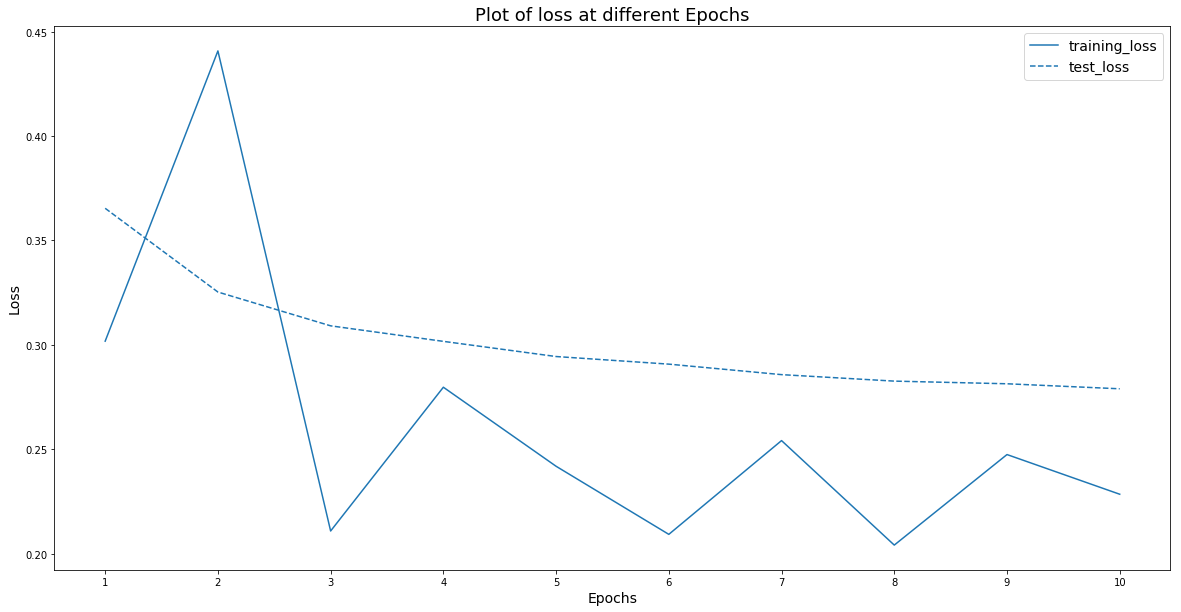

In [131]:
plt.figure(figsize=(20,10))
train_plot = plt.plot(model_metrics_linear_pd['epoch'], model_metrics_linear_pd['training_loss'])
plt.plot(model_metrics_linear_pd['epoch'], model_metrics_linear_pd['test_loss'],'--', color=train_plot[0].get_color())
plt.xlabel('Epochs', fontsize=14)
plt.xticks(model_metrics_linear_pd['epoch'])
plt.ylabel('Loss', fontsize=14)
plt.legend(loc=1, prop={'size': 14})
plt.title('Plot of loss at different Epochs', fontsize=18)
plt.show()

In [135]:
linear_test_loss, linear_test_accuracy = model_metrics_linear_pd['test_loss'][-1], model_metrics_linear_pd['test_accuracy'][-1]

### Linear Model - Performance on the test set at the end of training

In [136]:
print('Test Loss: {0:.4f}'.format(linear_test_loss))
print('Test Accuracy: {0:.3f}'.format(linear_test_accuracy))

Test Loss: 0.2790
Test Accuracy: 0.922


## Deep Model - Part 2 Question 5

In [24]:
model = Model(deep=True, activation=tf.nn.relu)

epochs = 10
step_counter = 0

model_metrics_deep = {}
model_metrics_deep['training_loss'] = []
model_metrics_deep['test_accuracy'] = []
model_metrics_deep['test_loss'] = []


writer = tf.contrib.summary.create_file_writer(logdir="logs/deep_model2", flush_millis=1000)
with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch_n in range(epochs):
            print('Epoch #%d' % (epoch_n))
            for (batch, (images, labels)) in enumerate(train_dataset):
                loss_value = train(model, images, labels)
                step_counter +=1
                tf.contrib.summary.scalar("loss", loss_value.numpy(), step=step_counter)

            tf.contrib.summary.scalar("loss_epoch", loss_value.numpy(), step=epoch_n)

        #     if step_counter % 100 == 0:
        #       print('Step #%d\tLoss: %.4f' % (step_counter, loss_value))

            test_accuracy = compute_accuracy(model(x_test), y_test)
            print('Accuracy #%.3f\n' % (test_accuracy))
            model_metrics_deep['training_loss'].append(loss_value.numpy())
            model_metrics_deep['test_accuracy'].append(test_accuracy.numpy())

            test_loss = loss(model(x_test), y_test)
            model_metrics_deep['test_loss'].append(test_loss.numpy())


writer.close()

Epoch #0
Accuracy #0.929

Epoch #1
Accuracy #0.952

Epoch #2
Accuracy #0.961

Epoch #3
Accuracy #0.968

Epoch #4
Accuracy #0.970

Epoch #5
Accuracy #0.973

Epoch #6
Accuracy #0.973

Epoch #7
Accuracy #0.975

Epoch #8
Accuracy #0.976

Epoch #9
Accuracy #0.977



In [27]:
model_metrics_deep_pd = pd.DataFrame.from_dict(model_metrics_deep).reset_index()
model_metrics_deep_pd['index'] = model_metrics_deep_pd['index']+1
model_metrics_deep_pd.rename(index=str, columns={'index':'epoch'}, inplace=True)

## Visualizing the training and test loss at different epochs

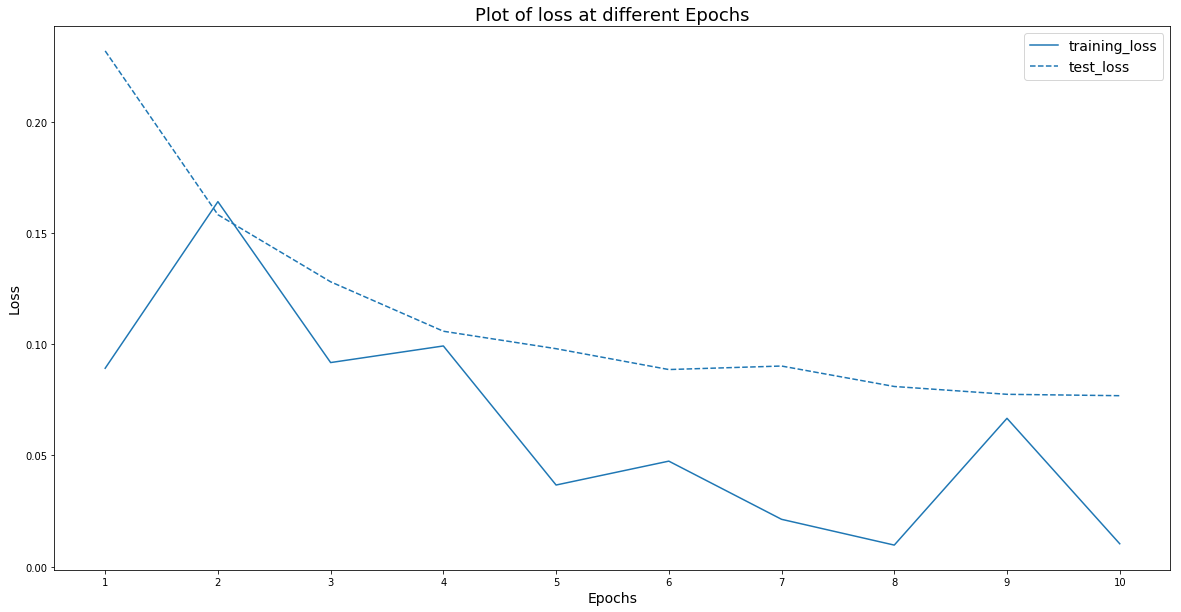

In [130]:
plt.figure(figsize=(20,10))
train_plot = plt.plot(model_metrics_deep_pd['epoch'], model_metrics_deep_pd['training_loss'])
plt.plot(model_metrics_deep_pd['epoch'], model_metrics_deep_pd['test_loss'],'--', color=train_plot[0].get_color())
plt.xlabel('Epochs', fontsize=14)
plt.xticks(model_metrics_deep_pd['epoch'])
plt.ylabel('Loss', fontsize=14)
plt.legend(loc=1, prop={'size': 14})
plt.title('Plot of loss at different Epochs', fontsize=18)
plt.show()

In [137]:
deep_test_loss, deep_test_accuracy = model_metrics_deep_pd['test_loss'][-1], model_metrics_deep_pd['test_accuracy'][-1]

### Deep Model - Performance on the test set at the end of training

In [138]:
print('Test Loss: {0:.4f}'.format(deep_test_loss))
print('Test Accuracy: {0:.3f}'.format(deep_test_accuracy))

Test Loss: 0.0768
Test Accuracy: 0.977


## Experiments to compare different parameter values for the deep model - Part 2 Question 6

### Function to execute the deep model with different parameters

In [92]:
def experiment_params(deep=False, learning_rate = 0.1, activation = tf.nn.relu, optimizer = tf.train.GradientDescentOptimizer, kernel_initializer='glorot_normal'):
    model = Model(deep=deep, activation=activation, kernel_initializer = kernel_initializer)
    optimizer = optimizer(learning_rate=learning_rate)

    epochs = 10
    step_counter = 0
    
    deep_flag_check = lambda x: 'deep' if x else 'linear'
    deep_flag = deep_flag_check(deep)
    
    prefix = deep_flag + '_' + optimizer.get_name() + '_' + str(learning_rate) +'_'+ activation.func_name + '_' + kernel_initializer
    
    model_metrics = {}
    model_metrics['training_loss'] = []
    model_metrics['test_accuracy'] = []
    model_metrics['test_loss'] = []
    
    writer = tf.contrib.summary.create_file_writer(logdir="logs/{}".format(prefix), flush_millis=1000)
    with writer.as_default():
        with tf.contrib.summary.always_record_summaries():
            for epoch_n in range(epochs):
                print('Epoch #%d' % (epoch_n))
                for (batch, (images, labels)) in enumerate(train_dataset):
                    loss_value = train(model, images, labels, optimizer)
                    step_counter +=1
                    tf.contrib.summary.scalar("loss", loss_value.numpy(), step=step_counter)

                tf.contrib.summary.scalar("loss_epoch", loss_value.numpy(), step=epoch_n)

            #     if step_counter % 100 == 0:
            #       print('Step #%d\tLoss: %.4f' % (step_counter, loss_value))

                test_accuracy = compute_accuracy(model(x_test), y_test)
                print('Accuracy #%.3f\n' % (test_accuracy))
                model_metrics['training_loss'].append(loss_value.numpy())
                model_metrics['test_accuracy'].append(test_accuracy.numpy())
                
                test_loss = loss(model(x_test), y_test)
                model_metrics['test_loss'].append(test_loss.numpy())

    writer.close()
    return model_metrics


## Running Various Combinations Individually

In [13]:
master_model_metrics = {}

# Optimizers
for optimizer in [tf.train.GradientDescentOptimizer, tf.train.AdamOptimizer, tf.train.AdagradOptimizer]:
    model_metrics = experiment_params(deep=True, learning_rate = 0.1, activation = tf.nn.relu, optimizer = optimizer, kernel_initializer='glorot_normal')
    master_model_metrics[optimizer(0.1).get_name()] = model_metrics

# Learning Rates    
for learning_rate in [0.001, 0.01, 0.1, 0.25]:
    model_metrics = experiment_params(deep=True, learning_rate = learning_rate, activation = tf.nn.relu, optimizer = tf.train.GradientDescentOptimizer, kernel_initializer='glorot_normal')
    master_model_metrics[str(learning_rate)] = model_metrics

# Activations
for activation in [tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh]:
    model_metrics = experiment_params(deep=True, learning_rate = 0.1, activation = activation, optimizer = tf.train.GradientDescentOptimizer, kernel_initializer='glorot_normal')
    master_model_metrics[activation.func_name] = model_metrics
    
# Initializers    
for kernel_initializer in ['glorot_normal', 'glorot_uniform', 'lecun_normal', 'RandomNormal']:
    model_metrics = experiment_params(deep=True, learning_rate = 0.1, activation = tf.nn.relu, optimizer = tf.train.GradientDescentOptimizer, kernel_initializer=kernel_initializer)
    master_model_metrics[kernel_initializer] = model_metrics


Epoch #0
Accuracy #0.333

Epoch #1
Accuracy #0.371

Epoch #2
Accuracy #0.367

Epoch #3
Accuracy #0.347

Epoch #4
Accuracy #0.386

Epoch #5
Accuracy #0.335

Epoch #6
Accuracy #0.177

Epoch #7
Accuracy #0.188

Epoch #8
Accuracy #0.198

Epoch #9
Accuracy #0.189

Epoch #0
Accuracy #0.956

Epoch #1
Accuracy #0.968

Epoch #2
Accuracy #0.974

Epoch #3
Accuracy #0.976

Epoch #4
Accuracy #0.974

Epoch #5
Accuracy #0.980

Epoch #6
Accuracy #0.976

Epoch #7
Accuracy #0.979

Epoch #8
Accuracy #0.979

Epoch #9
Accuracy #0.977

Epoch #0
Accuracy #0.435

Epoch #1
Accuracy #0.652

Epoch #2
Accuracy #0.736

Epoch #3
Accuracy #0.786

Epoch #4
Accuracy #0.820

Epoch #5
Accuracy #0.838

Epoch #6
Accuracy #0.851

Epoch #7
Accuracy #0.860

Epoch #8
Accuracy #0.867

Epoch #9
Accuracy #0.873

Epoch #0
Accuracy #0.861

Epoch #1
Accuracy #0.894

Epoch #2
Accuracy #0.906

Epoch #3
Accuracy #0.915

Epoch #4
Accuracy #0.920

Epoch #5
Accuracy #0.925

Epoch #6
Accuracy #0.930

Epoch #7
Accuracy #0.933

Epoch #8
Acc

### Obtaining the metrics for each model

In [97]:
master_model_metrics_df = pd.DataFrame.from_dict(master_model_metrics, orient='index')

### Plotting different activation functions - using a learning rate of 0.1, Gradient Descent Optimizer and Glorot Normal Initializer

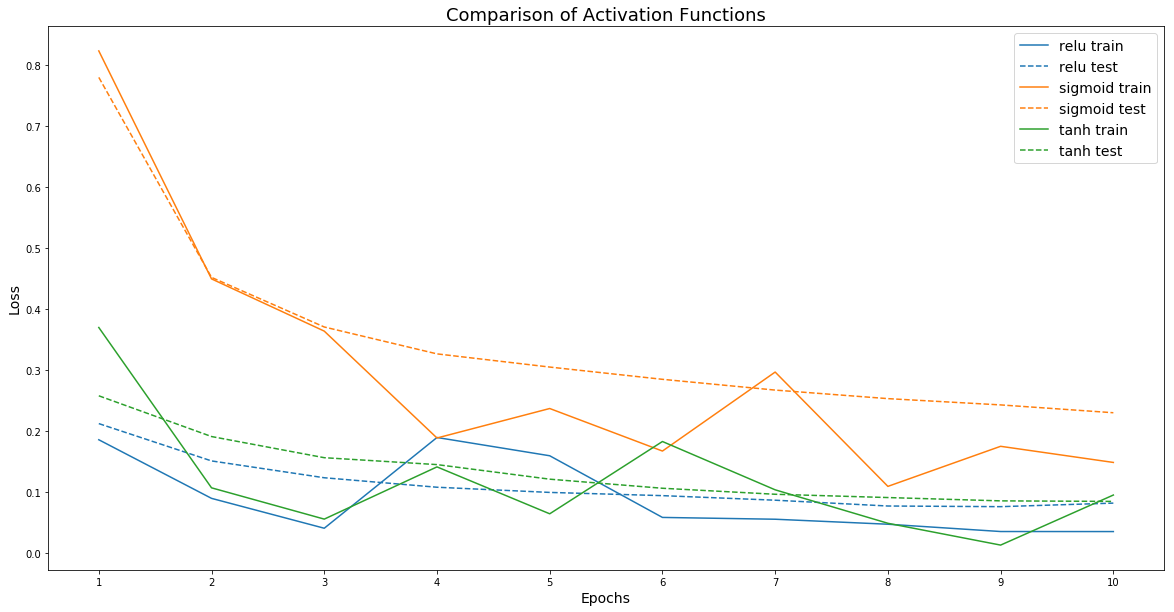

In [128]:
plt.figure(figsize=(20,10))
train_plot = plt.plot(range(1,11), master_model_metrics['relu']['training_loss'])
plt.plot(range(1,11), master_model_metrics['relu']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['sigmoid']['training_loss'])
plt.plot(range(1,11), master_model_metrics['sigmoid']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['tanh']['training_loss'])
plt.plot(range(1,11), master_model_metrics['tanh']['test_loss'] ,'--', color=train_plot[0].get_color())
plt.xlabel('Epochs', fontsize=14)
plt.xticks(model_metrics_linear_pd['epoch'])
plt.ylabel('Loss', fontsize=14)
plt.legend(['relu train','relu test', 'sigmoid train', 'sigmoid test', 'tanh train', 'tanh test'],loc=1, prop={'size': 14})
plt.title('Comparison of Activation Functions', fontsize=18)
plt.show()

### Activation Functions Comparison Summary
* **Based on the above plot, we notice that for the task at hand, the relu activation function performs the best as it has the lowest test loss. The tanh and the relu function perform comparably and are faster to train than the sigmoid function. The sigmoid function has the worst performance (highest test loss) based on 10 epochs of training but is generally decreasing and may need longer to train. The large regions of very small gradients of the sigmoid function might be contributing to the slower learning**
<br><br>
* **As expected the training loss generally continues to move in the downward direction with epochs. And based on the test loss curves, none of the models seem to be overfitting for 10 epochs**

*Note: Here, we are using the test set as a validation set to compare the different models as our goal is just to compare the models but not evaluate it (and also the starter code indicated that we need to report metrics on the test set) *

### Plotting different learning rates - using the relu activation function, Gradient Descent Optimizer and Glorot Normal Initializer

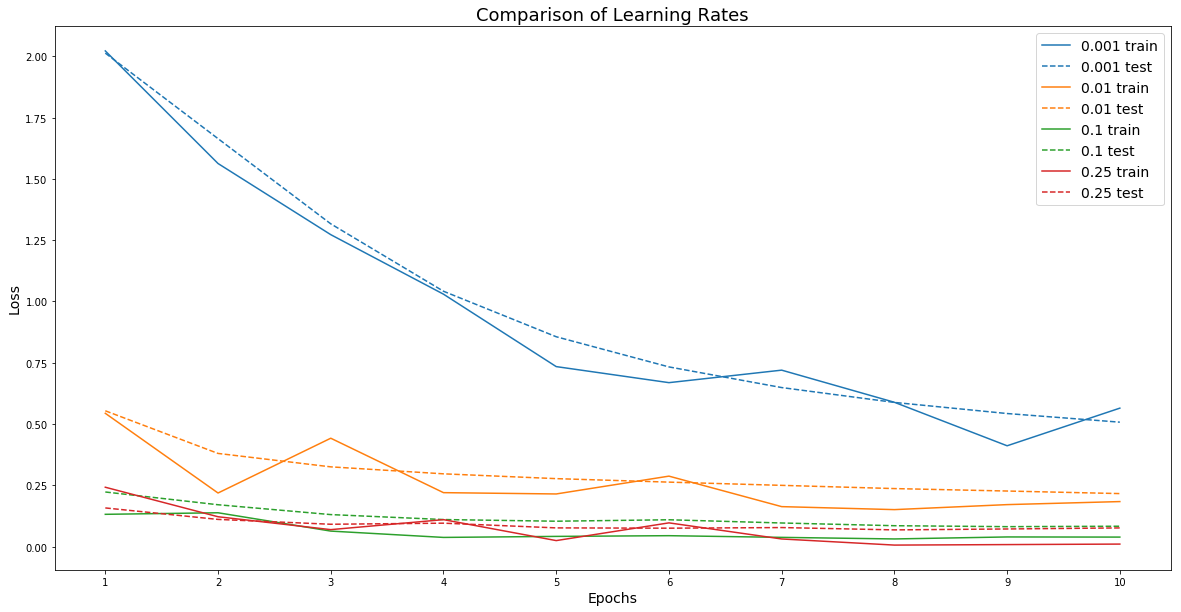

In [127]:
plt.figure(figsize=(20,10))
train_plot = plt.plot(range(1,11), master_model_metrics['0.001']['training_loss'])
plt.plot(range(1,11), master_model_metrics['0.001']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['0.01']['training_loss'])
plt.plot(range(1,11), master_model_metrics['0.01']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['0.1']['training_loss'])
plt.plot(range(1,11), master_model_metrics['0.1']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['0.25']['training_loss'])
plt.plot(range(1,11), master_model_metrics['0.25']['test_loss'] ,'--', color=train_plot[0].get_color())
plt.xlabel('Epochs', fontsize=14)
plt.xticks(model_metrics_linear_pd['epoch'])
plt.ylabel('Loss', fontsize=14)
plt.legend(['0.001 train','0.001 test', '0.01 train', '0.01 test', '0.1 train', '0.1 test', '0.25 train', '0.25 test'],loc=1, prop={'size': 14})
plt.title('Comparison of Learning Rates', fontsize=18)
plt.show()

### Plotting the above graph without learning rate of 0.001 as it doesn't perform as well

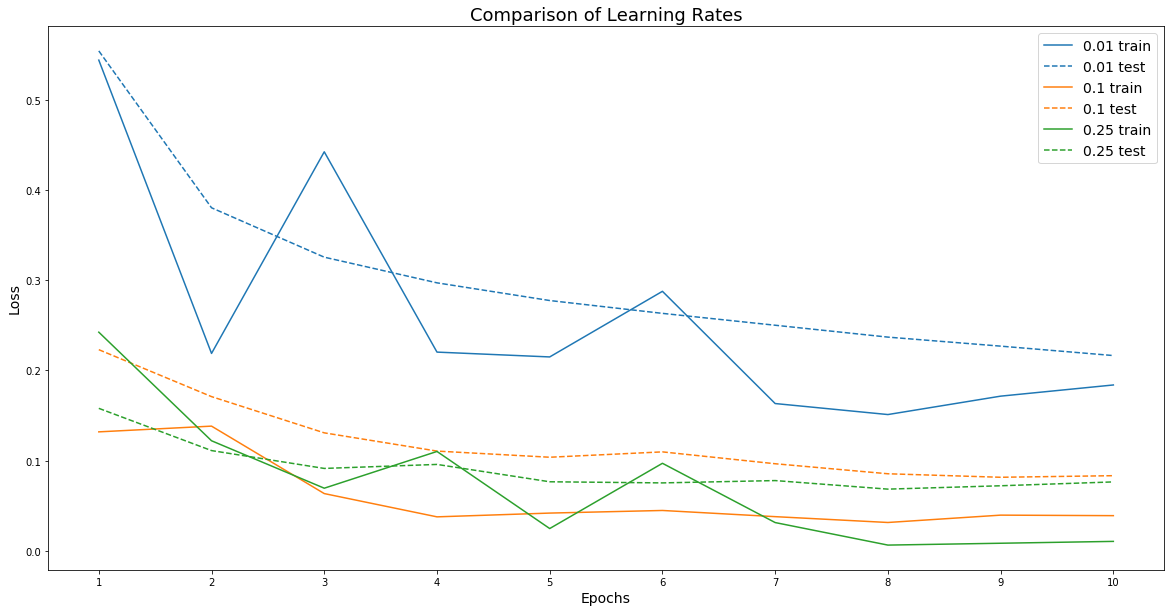

In [126]:
plt.figure(figsize=(20,10))
train_plot = plt.plot(range(1,11), master_model_metrics['0.01']['training_loss'])
plt.plot(range(1,11), master_model_metrics['0.01']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['0.1']['training_loss'])
plt.plot(range(1,11), master_model_metrics['0.1']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['0.25']['training_loss'])
plt.plot(range(1,11), master_model_metrics['0.25']['test_loss'] ,'--', color=train_plot[0].get_color())
plt.xlabel('Epochs', fontsize=14)
plt.xticks(model_metrics_linear_pd['epoch'])
plt.ylabel('Loss', fontsize=14)
plt.legend(['0.01 train', '0.01 test', '0.1 train', '0.1 test', '0.25 train', '0.25 test'],loc=1, prop={'size': 14})
plt.title('Comparison of Learning Rates', fontsize=18)
plt.show()

### Learning Rates Comparison Summary
* **Lower learning rates seem (0.001 and 0.01) seem to have a higher test loss but the loss is continuing to decrease with epochs indicating that the models need to be trained for longer. For the task at hand, these learning rates are probably too low and the model would have to be trained for much longer to achieve optimum loss**
<br><br>
* **Learning rates of 0.1 and 0.25 perform comparably. The model with a learning rate of 0.25 seems to have achieved the optimum loss at 8 epochs as the test loss seems to increase on further training (indicating overfitting). For 0.1, the test loss continues to decrease indicating no overfitting yet and so we might have to run the model for a bit longer**
<br><br>
* **The training loss for learning rate of 0.1 is very smooth (without oscillations) indicating a good learning rate. The training loss for learning rate of 0.25 has some oscillations but not too much**



*Note: Here, we are using the test set as a validation set to compare the different models as our goal is just to compare the models but not evaluate it (and also the starter code indicated that we need to report metrics on the test set) *

### Plotting different initializers - using the relu activation function, Gradient Descent Optimizer and learning rate of 0.1

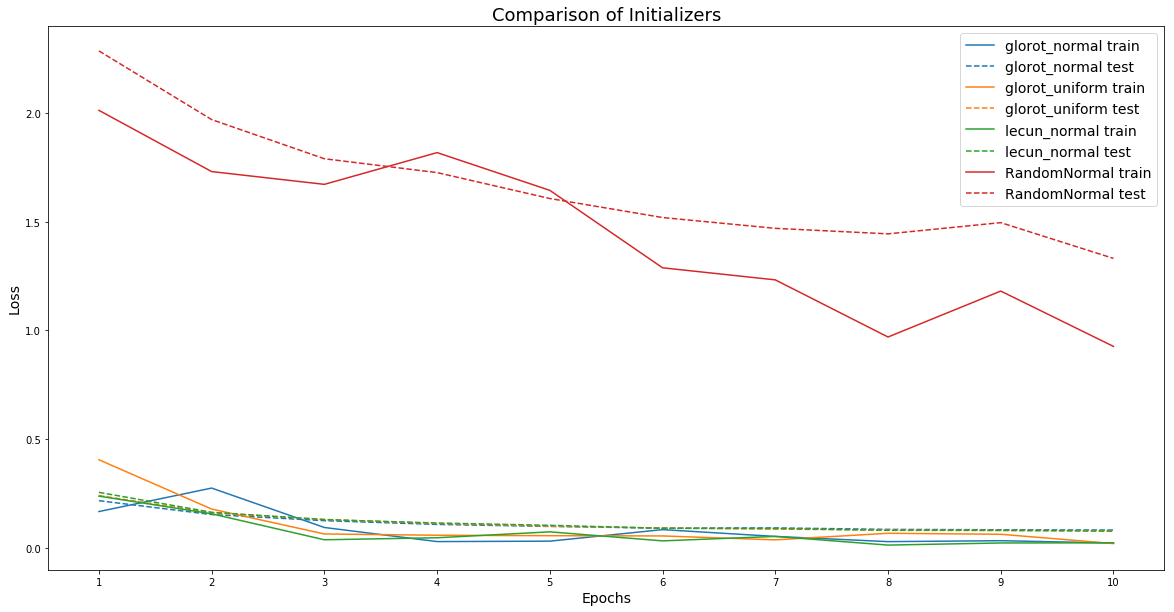

In [125]:
plt.figure(figsize=(20,10))
train_plot = plt.plot(range(1,11), master_model_metrics['glorot_normal']['training_loss'])
plt.plot(range(1,11), master_model_metrics['glorot_normal']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['glorot_uniform']['training_loss'])
plt.plot(range(1,11), master_model_metrics['glorot_uniform']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['lecun_normal']['training_loss'])
plt.plot(range(1,11), master_model_metrics['lecun_normal']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['RandomNormal']['training_loss'])
plt.plot(range(1,11), master_model_metrics['RandomNormal']['test_loss'] ,'--', color=train_plot[0].get_color())
plt.xlabel('Epochs', fontsize=14)
plt.xticks(model_metrics_linear_pd['epoch'])
plt.ylabel('Loss', fontsize=14)
plt.legend(['glorot_normal train','glorot_normal test', 'glorot_uniform train', 'glorot_uniform test', 'lecun_normal train', 'lecun_normal test', 'RandomNormal train', 'RandomNormal test'],loc=1, prop={'size': 14})
plt.title('Comparison of Initializers', fontsize=18)
plt.show()

### Plotting the above graph without the Random Normal Initializer as it doesn't perform as well

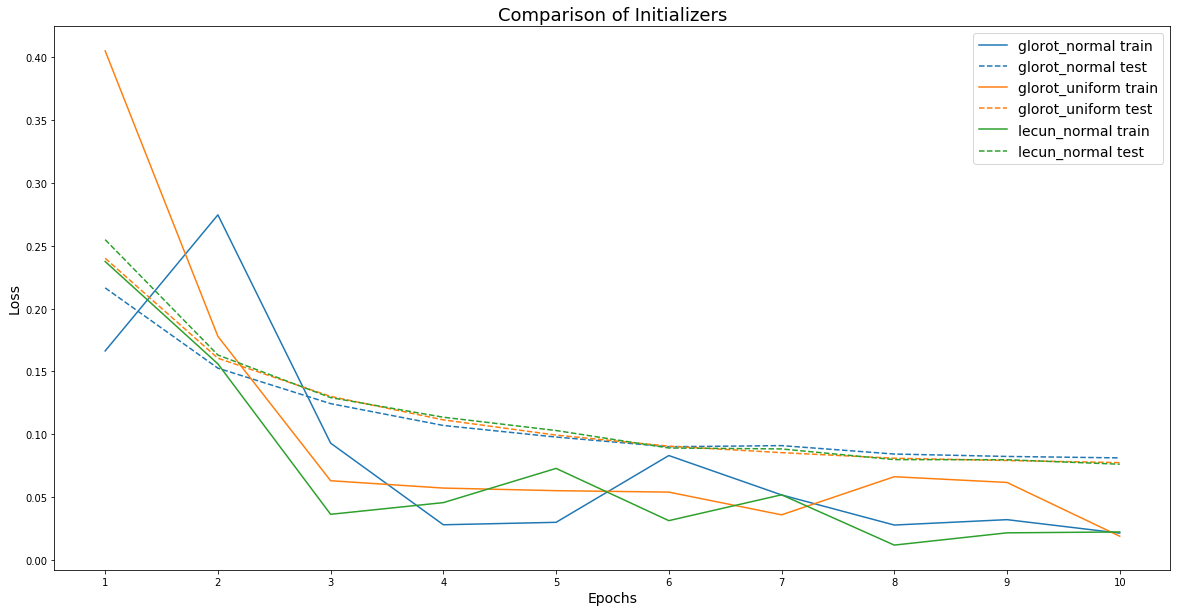

In [124]:
plt.figure(figsize=(20,10))
train_plot = plt.plot(range(1,11), master_model_metrics['glorot_normal']['training_loss'])
plt.plot(range(1,11), master_model_metrics['glorot_normal']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['glorot_uniform']['training_loss'])
plt.plot(range(1,11), master_model_metrics['glorot_uniform']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['lecun_normal']['training_loss'])
plt.plot(range(1,11), master_model_metrics['lecun_normal']['test_loss'] ,'--', color=train_plot[0].get_color())
plt.xlabel('Epochs', fontsize=14)
plt.xticks(model_metrics_linear_pd['epoch'])
plt.ylabel('Loss', fontsize=14)
plt.legend(['glorot_normal train','glorot_normal test', 'glorot_uniform train', 'glorot_uniform test', 'lecun_normal train', 'lecun_normal test'],loc=1, prop={'size': 14})
plt.title('Comparison of Initializers', fontsize=18)
plt.show()

### Initializers Comparison Summary
* **Glorot Normal, Glorot Uniform and Lecun Normal Initializers seem to have very similar performance on the test set based on the loss value. The curves also track each other very closely indicating that the choice of intializers (among these 3) does not really impact the performace too much. At 10 epochs, there is no indication of overfitting and hence the model can be run longer**
<br><br>
* **The Random Normal Initializer performs the worst among the four initializers. At a learning rate of 0.1, initializing the parameters using this mechanism might take very long to train well**

*Note: Here, we are using the test set as a validation set to compare the different models as our goal is just to compare the models but not evaluate it (and also the starter code indicated that we need to report metrics on the test set) *

### Plotting different optimizers - using the relu activation function, Glorot Normal Initializer and learning rate of 0.1

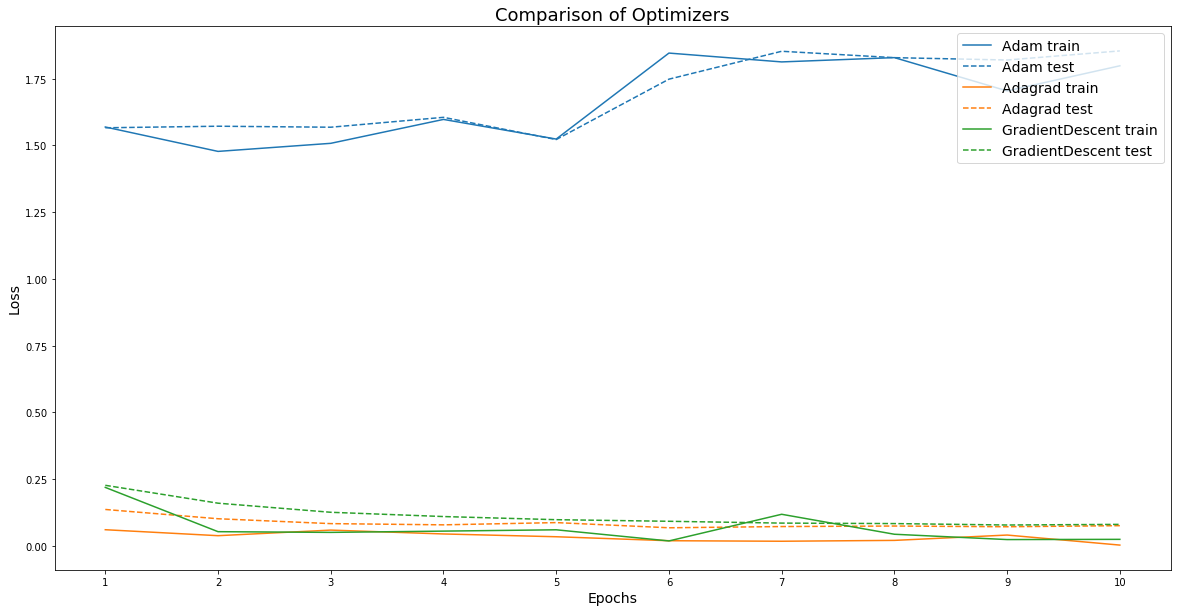

In [123]:
plt.figure(figsize=(20,10))
train_plot = plt.plot(range(1,11), master_model_metrics['Adam']['training_loss'])
plt.plot(range(1,11), master_model_metrics['Adam']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['Adagrad']['training_loss'])
plt.plot(range(1,11), master_model_metrics['Adagrad']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['GradientDescent']['training_loss'])
plt.plot(range(1,11), master_model_metrics['GradientDescent']['test_loss'] ,'--', color=train_plot[0].get_color())
plt.xlabel('Epochs', fontsize=14)
plt.xticks(model_metrics_linear_pd['epoch'])
plt.ylabel('Loss', fontsize=14)
plt.legend(['Adam train','Adam test', 'Adagrad train', 'Adagrad test', 'GradientDescent train', 'GradientDescent test'],loc=1, prop={'size': 14})
plt.title('Comparison of Optimizers', fontsize=18)
plt.show()

### Plotting the above graph without the Adam Optimizer as it doesn't perform as well with the given learning rate

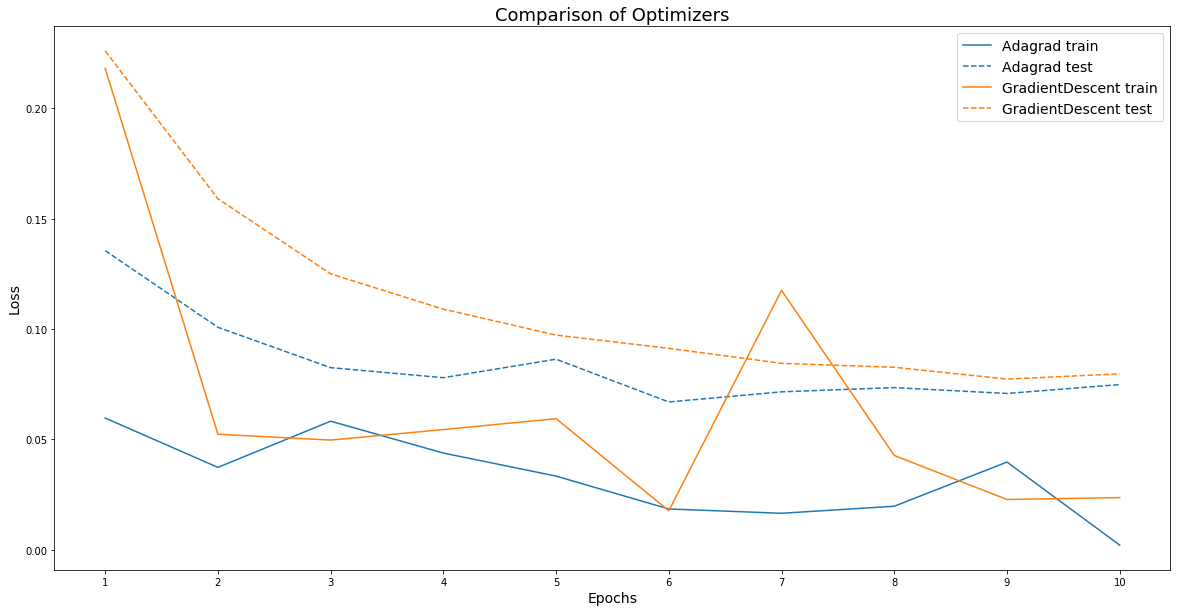

In [129]:
plt.figure(figsize=(20,10))
train_plot = plt.plot(range(1,11), master_model_metrics['Adagrad']['training_loss'])
plt.plot(range(1,11), master_model_metrics['Adagrad']['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), master_model_metrics['GradientDescent']['training_loss'])
plt.plot(range(1,11), master_model_metrics['GradientDescent']['test_loss'] ,'--', color=train_plot[0].get_color())
plt.xlabel('Epochs', fontsize=14)
plt.xticks(model_metrics_linear_pd['epoch'])
plt.ylabel('Loss', fontsize=14)
plt.legend(['Adagrad train', 'Adagrad test', 'GradientDescent train', 'GradientDescent test'],loc=1, prop={'size': 14})
plt.title('Comparison of Optimizers', fontsize=18)
plt.show()

### Optimizers Comparison Summary
* **Gradient Descent and Adagrad optimizers have comparable performance on the test loss. The test loss for gradient descent seems to continue to decrease indicating the model might have to be trained for a little longer to reach the optimum loss. But the adagrad model seems to have achieved optimum loss at epoch 6. The test loss increases on further training the adagrad model indicating some overfitting and so the adagrad algorithm seems to have trained pretty quickly**
<br><br>
* **The performance of the Adam Optimizer seems to be bad compared to the other two optimizers. This is probably because the learning rate of 0.1 is too high for the Adam optimizer. The performance of the Adam optimizer was much better with a learning rate of 0.001. This indicates that the various parameters interact with each other in a significant way and ideally (if we have enough computing power), we need to compare all combinations of parameters**

*Note: Here, we are using the test set as a validation set to compare the different models as our goal is just to compare the models but not evaluate it (and also the starter code indicated that we need to report metrics on the test set) *

## Extra Credit Questions
### Question 3 - Xavier Initialization

### Defining the custom Xavier Initialization Function using a Normal Distribution based on the Keras Documentation

Xavier Initialization involves initializing the weights based on a distribution (normal in this case) with 
**variance = 2/(n1 + n2)**
where n1 = # of neurons feeding in and
n2 = # of neurons the result is fed to

In [9]:
def xavier_normal(shape, dtype=None, partition_info=None):
    n1 = shape[0]
    n2 = shape[1]
    standard_dev = np.sqrt(2.0/(n1+n2))
    return tf.keras.backend.truncated_normal(shape = shape, mean = 0.0, stddev = standard_dev, dtype=dtype) 

### Running the deep model defined earlier with my implementation of Xavier Initialization

In [10]:
model = Model(deep=True, activation=tf.nn.relu, kernel_initializer=xavier_normal)

epochs = 10
step_counter = 0

model_metrics_xavier = {}
model_metrics_xavier['training_loss'] = []
model_metrics_xavier['test_accuracy'] = []
model_metrics_xavier['test_loss'] = []


writer = tf.contrib.summary.create_file_writer(logdir="logs/xavier_normal", flush_millis=1000)
with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch_n in range(epochs):
            print('Epoch #%d' % (epoch_n))
            for (batch, (images, labels)) in enumerate(train_dataset):
                loss_value = train(model, images, labels)
                step_counter +=1
                tf.contrib.summary.scalar("loss", loss_value.numpy(), step=step_counter)

            tf.contrib.summary.scalar("loss_epoch", loss_value.numpy(), step=epoch_n)

        #     if step_counter % 100 == 0:
        #       print('Step #%d\tLoss: %.4f' % (step_counter, loss_value))

            test_accuracy = compute_accuracy(model(x_test), y_test)
            print('Accuracy #%.3f\n' % (test_accuracy))
            model_metrics_xavier['training_loss'].append(loss_value.numpy())
            model_metrics_xavier['test_accuracy'].append(test_accuracy.numpy())

            test_loss = loss(model(x_test), y_test)
            model_metrics_xavier['test_loss'].append(test_loss.numpy())


writer.close()

Epoch #0
Accuracy #0.934

Epoch #1
Accuracy #0.950

Epoch #2
Accuracy #0.959

Epoch #3
Accuracy #0.967

Epoch #4
Accuracy #0.970

Epoch #5
Accuracy #0.974

Epoch #6
Accuracy #0.974

Epoch #7
Accuracy #0.975

Epoch #8
Accuracy #0.977

Epoch #9
Accuracy #0.977



### Running the deep model defined earlier with the builtin implementation of Xavier Initialization (glorot_normal)

In [11]:
model = Model(deep=True, activation=tf.nn.relu, kernel_initializer='glorot_normal')

epochs = 10
step_counter = 0

model_metrics_xavier_builtin = {}
model_metrics_xavier_builtin['training_loss'] = []
model_metrics_xavier_builtin['test_accuracy'] = []
model_metrics_xavier_builtin['test_loss'] = []


writer = tf.contrib.summary.create_file_writer(logdir="logs/xavier_normal_builtin", flush_millis=1000)
with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch_n in range(epochs):
            print('Epoch #%d' % (epoch_n))
            for (batch, (images, labels)) in enumerate(train_dataset):
                loss_value = train(model, images, labels)
                step_counter +=1
                tf.contrib.summary.scalar("loss", loss_value.numpy(), step=step_counter)

            tf.contrib.summary.scalar("loss_epoch", loss_value.numpy(), step=epoch_n)

        #     if step_counter % 100 == 0:
        #       print('Step #%d\tLoss: %.4f' % (step_counter, loss_value))

            test_accuracy = compute_accuracy(model(x_test), y_test)
            print('Accuracy #%.3f\n' % (test_accuracy))
            model_metrics_xavier_builtin['training_loss'].append(loss_value.numpy())
            model_metrics_xavier_builtin['test_accuracy'].append(test_accuracy.numpy())

            test_loss = loss(model(x_test), y_test)
            model_metrics_xavier_builtin['test_loss'].append(test_loss.numpy())


writer.close()

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Epoch #0
Accuracy #0.936

Epoch #1
Accuracy #0.952

Epoch #2
Accuracy #0.962

Epoch #3
Accuracy #0.967

Epoch #4
Accuracy #0.968

Epoch #5
Accuracy #0.969

Epoch #6
Accuracy #0.974

Epoch #7
Accuracy #0.976

Epoch #8
Accuracy #0.977

Epoch #9
Accuracy #0.975



### Running the deep model defined earlier with a Random Normal Initializer

In [17]:
model = Model(deep=True, activation=tf.nn.relu, kernel_initializer='RandomNormal')

epochs = 10
step_counter = 0

model_metrics_rn = {}
model_metrics_rn['training_loss'] = []
model_metrics_rn['test_accuracy'] = []
model_metrics_rn['test_loss'] = []


writer = tf.contrib.summary.create_file_writer(logdir="logs/rn", flush_millis=1000)
with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch_n in range(epochs):
            print('Epoch #%d' % (epoch_n))
            for (batch, (images, labels)) in enumerate(train_dataset):
                loss_value = train(model, images, labels)
                step_counter +=1
                tf.contrib.summary.scalar("loss", loss_value.numpy(), step=step_counter)

            tf.contrib.summary.scalar("loss_epoch", loss_value.numpy(), step=epoch_n)

        #     if step_counter % 100 == 0:
        #       print('Step #%d\tLoss: %.4f' % (step_counter, loss_value))

            test_accuracy = compute_accuracy(model(x_test), y_test)
            print('Accuracy #%.3f\n' % (test_accuracy))
            model_metrics_rn['training_loss'].append(loss_value.numpy())
            model_metrics_rn['test_accuracy'].append(test_accuracy.numpy())

            test_loss = loss(model(x_test), y_test)
            model_metrics_rn['test_loss'].append(test_loss.numpy())


writer.close()

Epoch #0
Accuracy #0.242

Epoch #1
Accuracy #0.279

Epoch #2
Accuracy #0.302

Epoch #3
Accuracy #0.321

Epoch #4
Accuracy #0.382

Epoch #5
Accuracy #0.348

Epoch #6
Accuracy #0.509

Epoch #7
Accuracy #0.590

Epoch #8
Accuracy #0.641

Epoch #9
Accuracy #0.675



### Plotting the loss against epochs for the Random Normal Initializer and the Custom and Builtin Xavier Initialization Implementations

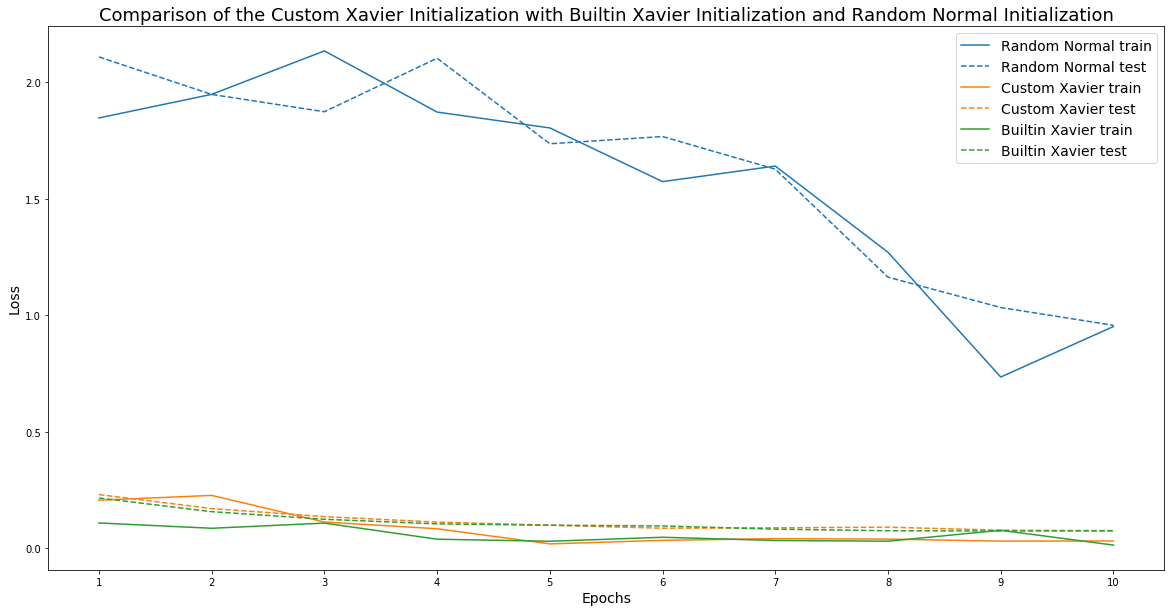

In [18]:
plt.figure(figsize=(20,10))
train_plot = plt.plot(range(1,11), model_metrics_rn['training_loss'])
plt.plot(range(1,11), model_metrics_rn['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), model_metrics_xavier['training_loss'])
plt.plot(range(1,11), model_metrics_xavier['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), model_metrics_xavier_builtin['training_loss'])
plt.plot(range(1,11), model_metrics_xavier_builtin['test_loss'] ,'--', color=train_plot[0].get_color())
plt.xlabel('Epochs', fontsize=14)
plt.xticks(range(1,11))
plt.ylabel('Loss', fontsize=14)
plt.legend(['Random Normal train', 'Random Normal test', 'Custom Xavier train', 'Custom Xavier test', 'Builtin Xavier train', 'Builtin Xavier test'],loc=1, prop={'size': 14})
plt.title('Comparison of the Custom Xavier Initialization with Builtin Xavier Initialization and Random Normal Initialization', fontsize=18)
plt.show()

### Plotting the above graph without the Random Normal Implementation as it has a higher loss

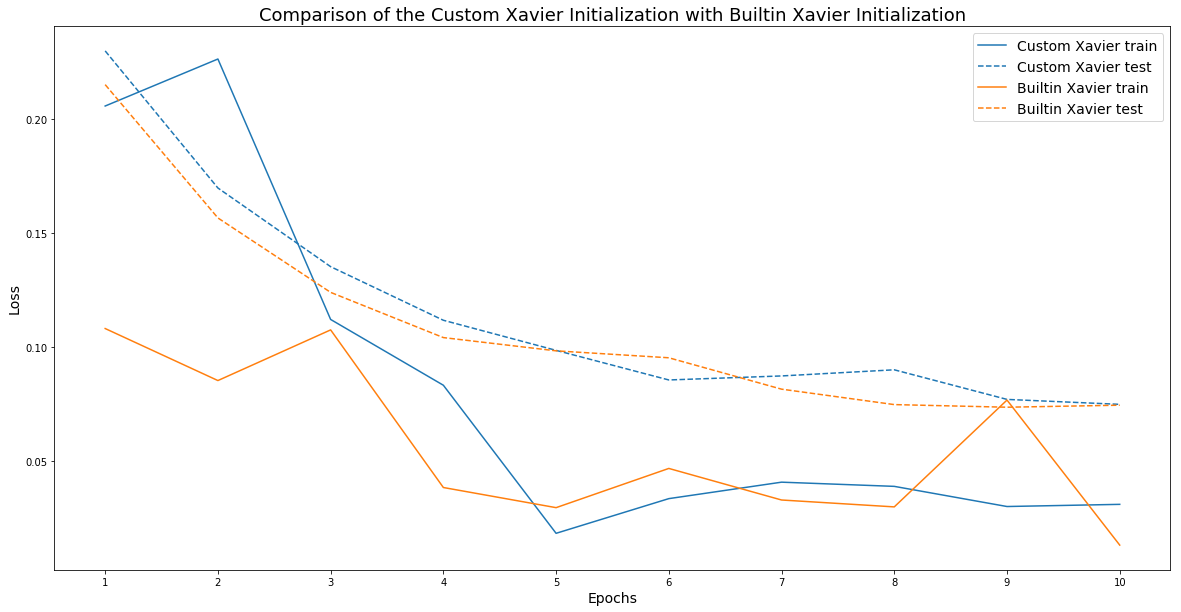

In [19]:
plt.figure(figsize=(20,10))
train_plot = plt.plot(range(1,11), model_metrics_xavier['training_loss'])
plt.plot(range(1,11), model_metrics_xavier['test_loss'] ,'--', color=train_plot[0].get_color())
train_plot = plt.plot(range(1,11), model_metrics_xavier_builtin['training_loss'])
plt.plot(range(1,11), model_metrics_xavier_builtin['test_loss'] ,'--', color=train_plot[0].get_color())
plt.xlabel('Epochs', fontsize=14)
plt.xticks(range(1,11))
plt.ylabel('Loss', fontsize=14)
plt.legend(['Custom Xavier train', 'Custom Xavier test', 'Builtin Xavier train', 'Builtin Xavier test'],loc=1, prop={'size': 14})
plt.title('Comparison of the Custom Xavier Initialization with Builtin Xavier Initialization', fontsize=18)
plt.show()

* **Based on the above graphs, we can say that the custom implementation of the Xavier Initialization performs much better than the simple Random Normal Initialization. The custom implementation performs as well as the builtin implementation of Xavier Initialization as the losses on the test are almost equal at the end of 10 epochs**

